In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.stats as ss
import seaborn as sns
sc.settings.set_figure_params(dpi=100)

In [2]:
# we'll read both of these values and the original input and irrelevant tcrs
cdr3_to_X_orig = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
ag_to_X_orig = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [3]:
# prepare the columns for cdr3 and ag
cdr3_cols = cdr3_to_X_orig.columns[cdr3_to_X_orig.columns.str.startswith('0')].str.slice(1)
ag_cols = ag_to_X_orig.columns[ag_to_X_orig.columns.str.startswith('0')].str.slice(1)

In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc, accuracy_score

2024-01-02 18:12:31.934751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 18:12:32.122478: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 18:12:32.933446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-02 18:12:32.933565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [22]:
# now do ablation study
def proc_ag(param):
    # setup environment to process an antigen columns
    ag_col, cdr3_to_X, ag_to_X, hit, irr = param
    print(ag_col)
    df_ablate = pd.DataFrame(columns=['ag_col','seed','auc','acc'])

    # complete 10 iterations
    for seed in range(10):
        ## SETUP CONSTANTS
        # grab a subset
        np.random.seed(seed)
        n_rows = hit.shape[0] // 2
        perc_train = 0.75


        ## SEPARATE OUT TRAINING AND TESTING
        # train and test
        # > subset target
        idxs = np.random.choice(hit.index, size=n_rows, replace=False)
        idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
        hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
        # > subset control
        idxs = np.random.choice(irr.index, size=n_rows, replace=False)
        idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
        irr_train, irr_test = irr.loc[idxs], irr.loc[idys]
        # confirm no overlap
        assert not hit_train.index.isin(hit_test.index).all()
        assert not irr_train.index.isin(irr_test.index).all()

        # validation
        # > subset target
        val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
        hit_val = hit.loc[val_idxs]
        # > subset control
        val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
        irr_val = irr.loc[val_idxs]


        ## CONVERT TO CORRECT FORMAT
        # create X for training
        X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
        X_train_cdr3s = cdr3_to_X.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
        X_train_epitopes = ag_to_X.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
        X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
        X_train = X_train_cdr3s.join(X_train_epitopes)

        # grab y for training
        y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])),
                             pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
        y_train = y_train.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_train.shape[0] == y_train.shape[0]

        # create X for testing
        X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
        X_test_cdr3s = cdr3_to_X.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
        X_test_epitopes = ag_to_X.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
        X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
        X_test = X_test_cdr3s.join(X_test_epitopes)

        # grab y for testing
        y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])),
                             pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
        y_test = y_test.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_test.shape[0] == y_test.shape[0]

        # create X for validation
        X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
        X_val_cdr3s = cdr3_to_X.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
        X_val_epitopes = ag_to_X.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
        X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
        X_val = X_val_cdr3s.join(X_val_epitopes)

        # grab y for validation
        y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])),
                             pd.Series(np.zeros(irr_val.shape[0]))], axis=0).astype(int)
        y_val = y_val.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_val.shape[0] == y_val.shape[0]

        # remove constant columns
        X_train = X_train.loc[:, X_train.nunique(0) > 1]
        X_train = X_train.loc[:, X_train.sum(0) > 0]
        # read in normalization factors
        means = X_train.mean(0)
        stds = (X_train - means).std(0)
        # subset for relevant columns
        X_train = X_train[means.index]
        X_test = X_test[means.index]
        X_val = X_val[means.index]
        # normalize
        X_train -= means
        X_train /= stds
        X_test -= means
        X_test /= stds
        X_val -= means
        X_val /= stds

        ## SETUP MODEL
        # retrieve the appropriate columns
        cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
        cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

        # determine model parameters
        # > layer for cdr3 alone
        input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
        output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
        # > layer for ag alone
        input_2 = keras.layers.Input(shape=(len(cols_ag)))
        output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
        # > combined layer
        concat_3 = keras.layers.Concatenate()([output_1, output_2])
        output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
        # > final logit softmax layer
        output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
        model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
        # set up the training parameters for the model
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy','AUC'],
        )
        # train the model
        history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                            epochs=10,
                            validation_data=([X_test[cols_cdr3], X_test[cols_ag]], y_test),
                            workers=40, use_multiprocessing=True)

        # testing predictions
        y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                               workers=40, use_multiprocessing=True)[:, 0]
        y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
        y_pred = pd.concat([y_pred, y_val], axis=1)

        # retrieve auc metrics
        fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
        # add values
        df_ablate.loc[df_ablate.shape[0]] = ag_col, seed, auc(fpr, tpr), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))
    return df_ablate

In [24]:
# derive the parameters
params = []
finished = ['T','S','Y','weight','N','aromatic','P',
            'A','L','I','sulfur','W','V','R',
            'F','D','E','H','K','M','Q','charge']
for ag_col in ag_cols:
    # skip ones we have already finished
    if ag_col in finished:
        print(ag_col)
        continue
    # derive columns to ablate
    ag_ablate = pd.Series(np.arange(15)).astype(str) + ag_col
    # derive new matrices
    ag_to_X = ag_to_X_orig.loc[:, ~ag_to_X_orig.columns.isin(ag_ablate)]
    # now setup the parameters
    params.append([ag_col, cdr3_to_X_orig, ag_to_X, hit, irr])
# now do the multiprocessing
import multiprocessing as mp
from tqdm import tqdm
# els = []
with mp.Pool(4) as pool:
    for el in tqdm(pool.imap_unordered(proc_ag, params)):
        els.append(el)

A
D
E
F
H
I
K
L
M
N
P
Q
R
S
T
V
W
Y
charge
weight
sulfur
aromatic


0it [00:00, ?it/s]

C
G
hydrophobicity


2024-01-02 21:33:07.218160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-01-02 21:33:07.218215: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-02 21:33:07.218772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


2024-01-02 21:33:08.633543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-01-02 21:33:08.633602: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-02 21:33:08.634113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 292/2977 [=>............................] - ETA: 10s - loss: 0.6707 - accuracy: 0.5705 - auc: 0.6101

2024-01-02 21:33:10.353706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-01-02 21:33:10.353747: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-02 21:33:10.354329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2977/2977 [==============================] - 14s 4ms/step - loss: 0.6084 - accuracy: 0.6258 - auc: 0.6966 - val_loss: 0.5755 - val_accuracy: 0.6630 - val_auc: 0.7448
Epoch 2/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.6084 - accuracy: 0.6243 - auc: 0.6957 - val_loss: 0.5721 - val_accuracy: 0.6645 - val_auc: 0.7467
Epoch 2/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6093 - accuracy: 0.6223 - auc: 0.6936 - val_loss: 0.5730 - val_accuracy: 0.6599 - val_auc: 0.7448
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5487 - accuracy: 0.6875 - auc: 0.7733 - val_loss: 0.5390 - val_accuracy: 0.6948 - val_auc: 0.7876
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5503 - accuracy: 0.6836 - auc: 0.7705 - val_loss: 0.5369 - val_accuracy: 0.6972 - val_auc: 0.7872
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5516 - accuracy: 0.6843 - auc: 0.7706 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.3781 - accuracy: 0.8156 - auc: 0.9082 - val_loss: 0.4727 - val_accuracy: 0.7668 - val_auc: 0.8604
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3811 - accuracy: 0.8159 - auc: 0.9071 - val_loss: 0.4679 - val_accuracy: 0.7682 - val_auc: 0.8598
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3823 - accuracy: 0.8164 - auc: 0.9063 - val_loss: 0.4864 - val_accuracy: 0.7601 - val_auc: 0.8560
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3253 - accuracy: 0.8480 - auc: 0.9337 - val_loss: 0.4754 - val_accuracy: 0.7742 - val_auc: 0.8735
Epoch 7/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3260 - accuracy: 0.8468 - auc: 0.9337 - val_loss: 0.4626 - val_accuracy: 0.7817 - val_auc: 0.8740
Epoch 7/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3285 - accuracy: 0.8477 - auc: 0.9327 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.2141 - accuracy: 0.9065 - auc: 0.9722 - val_loss: 0.5020 - val_accuracy: 0.8020 - val_auc: 0.8847
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2169 - accuracy: 0.9063 - auc: 0.9715 - val_loss: 0.5173 - val_accuracy: 0.7920 - val_auc: 0.8808
Epoch 10/10
3970/3970 [==============================] - 7s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6082 - accuracy: 0.6253 - auc: 0.6954 - val_loss: 0.5788 - val_accuracy: 0.6508 - val_auc: 0.7364
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6081 - accuracy: 0.6222 - auc: 0.6946 - val_loss: 0.5746 - val_accuracy: 0.6593 - val_auc: 0.7410
Epoch 2/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6081 - accuracy: 0.6234 - auc: 0.6940 - val_loss: 0.5791 - val_accuracy: 0.6516 - val_auc: 0.7350
Epoch 2/10
2977/2977 [==============================] - 

2977/2977 [==============================] - 13s 4ms/step - loss: 0.5035 - accuracy: 0.7284 - auc: 0.8206 - val_loss: 0.5167 - val_accuracy: 0.7175 - val_auc: 0.8123
Epoch 4/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5521 - accuracy: 0.6838 - auc: 0.7701 - val_loss: 0.5494 - val_accuracy: 0.6788 - val_auc: 0.7820
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5058 - accuracy: 0.7229 - auc: 0.8172 - val_loss: 0.5139 - val_accuracy: 0.7174 - val_auc: 0.8125
Epoch 4/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4449 - accuracy: 0.7735 - auc: 0.8677 - val_loss: 0.4838 - val_accuracy: 0.7517 - val_auc: 0.8428
Epoch 5/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.4457 - accuracy: 0.7713 - auc: 0.8660 - val_loss: 0.4904 - val_accuracy: 0.7437 - val_auc: 0.8389
Epoch 5/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3814 - accuracy: 0.8156 - auc: 0.9068 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.3835 - accuracy: 0.8143 - auc: 0.9056 - val_loss: 0.4725 - val_accuracy: 0.7686 - val_auc: 0.8587
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3229 - accuracy: 0.8496 - auc: 0.9348 - val_loss: 0.4829 - val_accuracy: 0.7728 - val_auc: 0.8647
Epoch 7/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3281 - accuracy: 0.8475 - auc: 0.9328 - val_loss: 0.4675 - val_accuracy: 0.7805 - val_auc: 0.8693
Epoch 7/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2782 - accuracy: 0.8747 - auc: 0.9523 - val_loss: 0.4726 - val_accuracy: 0.7914 - val_auc: 0.8798
Epoch 8/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2508 - accuracy: 0.8892 - auc: 0.9615 - val_loss: 0.4921 - val_accuracy: 0.7886 - val_auc: 0.8768
Epoch 9/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2844 - accuracy: 0.8719 - auc: 0.9502 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.2260 - accuracy: 0.9004 - auc: 0.9689 - val_loss: 0.5245 - val_accuracy: 0.7883 - val_auc: 0.8787
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2498 - accuracy: 0.8899 - auc: 0.9619 - val_loss: 0.4830 - val_accuracy: 0.7967 - val_auc: 0.8820
Epoch 9/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2189 - accuracy: 0.9059 - auc: 0.9709 - val_loss: 0.5018 - val_accuracy: 0.7985 - val_auc: 0.8834
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6101 - accuracy: 0.6220 - auc: 0.6932 - val_loss: 0.5812 - val_accuracy: 0.6531 - val_auc: 0.7368
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6082 - accuracy: 0.6265 - auc: 0.6983 - val_loss: 0.5765 - val_accuracy: 0.6616 - val_auc: 0.7461
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5538 - accuracy: 0.6822 - auc: 0.7679 - val_l

Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5525 - accuracy: 0.6846 - auc: 0.7695 - val_loss: 0.5398 - val_accuracy: 0.6983 - val_auc: 0.7862
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.6090 - accuracy: 0.6251 - auc: 0.6957 - val_loss: 0.5785 - val_accuracy: 0.6626 - val_auc: 0.7417
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5515 - accuracy: 0.6856 - auc: 0.7713 - val_loss: 0.5452 - val_accuracy: 0.6936 - val_auc: 0.7816
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5052 - accuracy: 0.7264 - auc: 0.8189 - val_loss: 0.5155 - val_accuracy: 0.7207 - val_auc: 0.8115
Epoch 4/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5542 - accuracy: 0.6841 - auc: 0.7680 - val_loss: 0.5451 - val_accuracy: 0.6914 - val_auc: 0.7789
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4485 - accuracy: 0.7720 - auc: 0.864

2977/2977 [==============================] - 13s 4ms/step - loss: 0.3810 - accuracy: 0.8169 - auc: 0.9074 - val_loss: 0.4725 - val_accuracy: 0.7680 - val_auc: 0.8590
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3847 - accuracy: 0.8156 - auc: 0.9054 - val_loss: 0.4704 - val_accuracy: 0.7688 - val_auc: 0.8588
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3290 - accuracy: 0.8473 - auc: 0.9325 - val_loss: 0.4617 - val_accuracy: 0.7821 - val_auc: 0.8715
Epoch 7/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3283 - accuracy: 0.8486 - auc: 0.9330 - val_loss: 0.4716 - val_accuracy: 0.7791 - val_auc: 0.8682
Epoch 7/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.3856 - accuracy: 0.8136 - auc: 0.9043 - val_loss: 0.4667 - val_accuracy: 0.7688 - val_auc: 0.8601
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2840 - accuracy: 0.8723 - auc: 0.9506 - val_los

1it [24:37, 1477.94s/it]

2966/2977 [============================>.] - ETA: 0s - loss: 0.1979 - accuracy: 0.9152 - auc: 0.9764

2it [24:48, 615.07s/it] 

3970/3970 [==============================] - 9s 2ms/step


3it [25:03, 501.16s/it]


In [25]:
import pickle as pkl
with open('tmp.ag.csv.pkl', 'wb') as f:
    pkl.dump(els, f)

In [5]:
# now do ablation study
def proc_cdr3(param):
    # setup environment to process an antigen columns
    cdr3_col, cdr3_to_X, ag_to_X, hit, irr = param
    print(cdr3_col)
    df_ablate = pd.DataFrame(columns=['cdr3_col','seed','auc','acc'])

    # complete 10 iterations
    for seed in range(10):
        ## SETUP CONSTANTS
        # grab a subset
        np.random.seed(seed)
        n_rows = hit.shape[0] // 2
        perc_train = 0.75


        ## SEPARATE OUT TRAINING AND TESTING
        # train and test
        # > subset target
        idxs = np.random.choice(hit.index, size=n_rows, replace=False)
        idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
        hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
        # > subset control
        idxs = np.random.choice(irr.index, size=n_rows, replace=False)
        idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
        irr_train, irr_test = irr.loc[idxs], irr.loc[idys]
        # confirm no overlap
        assert not hit_train.index.isin(hit_test.index).all()
        assert not irr_train.index.isin(irr_test.index).all()

        # validation
        # > subset target
        val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
        hit_val = hit.loc[val_idxs]
        # > subset control
        val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
        irr_val = irr.loc[val_idxs]


        ## CONVERT TO CORRECT FORMAT
        # create X for training
        X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
        X_train_cdr3s = cdr3_to_X.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
        X_train_epitopes = ag_to_X.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
        X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
        X_train = X_train_cdr3s.join(X_train_epitopes)

        # grab y for training
        y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])),
                             pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
        y_train = y_train.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_train.shape[0] == y_train.shape[0]

        # create X for testing
        X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
        X_test_cdr3s = cdr3_to_X.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
        X_test_epitopes = ag_to_X.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
        X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
        X_test = X_test_cdr3s.join(X_test_epitopes)

        # grab y for testing
        y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])),
                             pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
        y_test = y_test.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_test.shape[0] == y_test.shape[0]

        # create X for validation
        X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
        X_val_cdr3s = cdr3_to_X.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
        X_val_epitopes = ag_to_X.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
        # combine
        X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
        X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
        X_val = X_val_cdr3s.join(X_val_epitopes)

        # grab y for validation
        y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])),
                             pd.Series(np.zeros(irr_val.shape[0]))], axis=0).astype(int)
        y_val = y_val.reset_index().iloc[:, 1:][0]

        # confirm the same length
        assert X_val.shape[0] == y_val.shape[0]

        # remove constant columns
        X_train = X_train.loc[:, X_train.nunique(0) > 1]
        X_train = X_train.loc[:, X_train.sum(0) > 0]
        # read in normalization factors
        means = X_train.mean(0)
        stds = (X_train - means).std(0)
        # subset for relevant columns
        X_train = X_train[means.index]
        X_test = X_test[means.index]
        X_val = X_val[means.index]
        # normalize
        X_train -= means
        X_train /= stds
        X_test -= means
        X_test /= stds
        X_val -= means
        X_val /= stds

        ## SETUP MODEL
        # retrieve the appropriate columns
        cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
        cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

        # determine model parameters
        # > layer for cdr3 alone
        input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
        output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
        # > layer for ag alone
        input_2 = keras.layers.Input(shape=(len(cols_ag)))
        output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
        # > combined layer
        concat_3 = keras.layers.Concatenate()([output_1, output_2])
        output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
        # > final logit softmax layer
        output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
        model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
        # set up the training parameters for the model
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy','AUC'],
        )
        # train the model
        history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                            epochs=10,
                            validation_data=([X_test[cols_cdr3], X_test[cols_ag]], y_test),
                            workers=40, use_multiprocessing=True)

        # testing predictions
        y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                               workers=40, use_multiprocessing=True)[:, 0]
        y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
        y_pred = pd.concat([y_pred, y_val], axis=1)

        # retrieve auc metrics
        fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
        # add values
        df_ablate.loc[df_ablate.shape[0]] = cdr3_col, seed, auc(fpr, tpr), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))
    return df_ablate

In [7]:
# derive the parameters
params = []
for cdr3_col in cdr3_cols:
    # derive columns to ablate
    cdr3_ablate = pd.Series(np.arange(30)).astype(str) + cdr3_col
    # derive new matrices
    cdr3_to_X = cdr3_to_X_orig.loc[:, ~cdr3_to_X_orig.columns.isin(cdr3_ablate)]
    # now setup the parameters
    params.append([cdr3_col, cdr3_to_X, ag_to_X_orig, hit, irr])
# now do the multiprocessing
import multiprocessing as mp
from tqdm import tqdm
els = []
with mp.Pool(4) as pool:
    for el in tqdm(pool.imap_unordered(proc_cdr3, params)):
        els.append(el)
#         with open('tmp.cdr3.csv.pkl', 'wb') as f:
#             pkl.dump(els, f)

0it [00:00, ?it/s]

A
C
D
E


2024-01-02 18:13:17.871223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-01-02 18:13:17.871280: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-02 18:13:17.871921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


2024-01-02 18:13:21.011518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-01-02 18:13:21.011573: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-02 18:13:21.012138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 776/2977 [======>.......................] - ETA: 8s - loss: 0.6498 - accuracy: 0.5858 - auc: 0.6384

2024-01-02 18:13:24.789115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-01-02 18:13:24.789170: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-02 18:13:24.789825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1826/2977 [=================>............] - ETA: 4s - loss: 0.6237 - accuracy: 0.6032 - auc: 0.6690

2024-01-02 18:13:28.218361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-01-02 18:13:28.218410: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-02 18:13:28.218888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2977/2977 [==============================] - 15s 5ms/step - loss: 0.6091 - accuracy: 0.6221 - auc: 0.6935 - val_loss: 0.5766 - val_accuracy: 0.6574 - val_auc: 0.7368
Epoch 2/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6078 - accuracy: 0.6260 - auc: 0.6971 - val_loss: 0.5696 - val_accuracy: 0.6685 - val_auc: 0.7483
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6129 - accuracy: 0.6199 - auc: 0.6898 - val_loss: 0.5779 - val_accuracy: 0.6584 - val_auc: 0.7415
Epoch 2/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6073 - accuracy: 0.6265 - auc: 0.6973 - val_loss: 0.5718 - val_accuracy: 0.6640 - val_auc: 0.7449
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5532 - accuracy: 0.6832 - auc: 0.7678 - val_loss: 0.5431 - val_accuracy: 0.6940 - val_auc: 0.7805
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5481 - accuracy: 0.6908 - auc: 0.7745 - val_los

2977/2977 [==============================] - 14s 4ms/step - loss: 0.6091 - accuracy: 0.6219 - auc: 0.6924 - val_loss: 0.5800 - val_accuracy: 0.6549 - val_auc: 0.7338
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6093 - accuracy: 0.6222 - auc: 0.6924 - val_loss: 0.5819 - val_accuracy: 0.6478 - val_auc: 0.7333
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5551 - accuracy: 0.6815 - auc: 0.7653 - val_loss: 0.5477 - val_accuracy: 0.6875 - val_auc: 0.7797
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5544 - accuracy: 0.6813 - auc: 0.7653 - val_loss: 0.5430 - val_accuracy: 0.6901 - val_auc: 0.7829
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5517 - accuracy: 0.6835 - auc: 0.7680 - val_loss: 0.5456 - val_accuracy: 0.6915 - val_auc: 0.7807
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5091 - accuracy: 0.7231 - auc: 0.8144 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6092 - accuracy: 0.6230 - auc: 0.6942 - val_loss: 0.5790 - val_accuracy: 0.6565 - val_auc: 0.7380
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6092 - accuracy: 0.6247 - auc: 0.6954 - val_loss: 0.5807 - val_accuracy: 0.6576 - val_auc: 0.7381
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5540 - accuracy: 0.6834 - auc: 0.7676 - val_loss: 0.5468 - val_accuracy: 0.6916 - val_auc: 0.7789
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6091 - accuracy: 0.6273 - auc: 0.6962 - val_loss: 0.5787 - val_accuracy: 0.6581 - val_auc: 0.7366
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6090 - accuracy: 0.6273 - auc: 0.6969 - val_loss: 0.5762 - val_accuracy: 0.6642 - val_auc: 0.7428
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5545 - accuracy: 0.6831 - auc: 0.7685 - val_los

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2252 - accuracy: 0.9012 - auc: 0.9692 - val_loss: 0.5005 - val_accuracy: 0.7955 - val_auc: 0.8803
Epoch 10/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6089 - accuracy: 0.6245 - auc: 0.6952 - val_loss: 0.5779 - val_accuracy: 0.6597 - val_auc: 0.7403
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6093 - accuracy: 0.6190 - auc: 0.6909 - val_loss: 0.5839 - val_accuracy: 0.6442 - val_auc: 0.7344
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5517 - accuracy: 0.6839 - auc: 0.7699 - val_loss: 0.5423 - val_accuracy: 0.6939 - val_auc: 0.7815
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6091 - accuracy: 0.6200 - auc: 0.6927 - val_loss: 0.5787 - val_accuracy: 0.6550 - val_auc: 0.7347
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5567 - accuracy: 0.6787 - auc: 0.7634 - val_lo

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2238 - accuracy: 0.9041 - auc: 0.9697 - val_loss: 0.5072 - val_accuracy: 0.7887 - val_auc: 0.8803
Epoch 10/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6098 - accuracy: 0.6231 - auc: 0.6932 - val_loss: 0.5787 - val_accuracy: 0.6600 - val_auc: 0.7363
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5556 - accuracy: 0.6799 - auc: 0.7657 - val_loss: 0.5535 - val_accuracy: 0.6793 - val_auc: 0.7754
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6082 - accuracy: 0.6246 - auc: 0.6960 - val_loss: 0.5773 - val_accuracy: 0.6554 - val_auc: 0.7380
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6071 - accuracy: 0.6256 - auc: 0.6968 - val_loss: 0.5750 - val_accuracy: 0.6629 - val_auc: 0.7476
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5095 - accuracy: 0.7211 - auc: 0.8140 - val_lo

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2295 - accuracy: 0.8999 - auc: 0.9681 - val_loss: 0.4864 - val_accuracy: 0.7963 - val_auc: 0.8841
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2559 - accuracy: 0.8850 - auc: 0.9600 - val_loss: 0.4721 - val_accuracy: 0.7950 - val_auc: 0.8822
Epoch 9/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2265 - accuracy: 0.9014 - auc: 0.9689 - val_loss: 0.4863 - val_accuracy: 0.7972 - val_auc: 0.8837
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2177 - accuracy: 0.9056 - auc: 0.9714 - val_loss: 0.4912 - val_accuracy: 0.8042 - val_auc: 0.8875
Epoch 10/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6102 - accuracy: 0.6223 - auc: 0.6926 - val_loss: 0.5831 - val_accuracy: 0.6502 - val_auc: 0.7384
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5577 - accuracy: 0.6794 - auc: 0.7625 - val_

Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2913 - accuracy: 0.8669 - auc: 0.9475 - val_loss: 0.4818 - val_accuracy: 0.7822 - val_auc: 0.8723
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2552 - accuracy: 0.8858 - auc: 0.9602 - val_loss: 0.4987 - val_accuracy: 0.7866 - val_auc: 0.8768
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2500 - accuracy: 0.8896 - auc: 0.9618 - val_loss: 0.4890 - val_accuracy: 0.7913 - val_auc: 0.8800
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2239 - accuracy: 0.9024 - auc: 0.9696 - val_loss: 0.5015 - val_accuracy: 0.7948 - val_auc: 0.8837
Epoch 10/10
2977/2977 [==============================] - 10s 3ms/step - loss: 0.2246 - accuracy: 0.9019 - auc: 0.9694 - val_loss: 0.5191 - val_accuracy: 0.7916 - val_auc: 0.8783
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2555 - accuracy: 0.8857 - auc: 0.9

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2887 - accuracy: 0.8695 - auc: 0.9486 - val_loss: 0.4696 - val_accuracy: 0.7850 - val_auc: 0.8749
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2572 - accuracy: 0.8860 - auc: 0.9595 - val_loss: 0.4793 - val_accuracy: 0.7926 - val_auc: 0.8787
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2595 - accuracy: 0.8839 - auc: 0.9586 - val_loss: 0.4967 - val_accuracy: 0.7813 - val_auc: 0.8750
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2900 - accuracy: 0.8676 - auc: 0.9480 - val_loss: 0.4726 - val_accuracy: 0.7864 - val_auc: 0.8751
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2523 - accuracy: 0.8880 - auc: 0.9612 - val_loss: 0.4802 - val_accuracy: 0.7932 - val_auc: 0.8803
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2260 - accuracy: 0.9017 - auc: 0.9690 - val_los

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2803 - accuracy: 0.8740 - auc: 0.9517 - val_loss: 0.4736 - val_accuracy: 0.7924 - val_auc: 0.8798
Epoch 8/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.2979 - accuracy: 0.8618 - auc: 0.9449 - val_loss: 0.4802 - val_accuracy: 0.7835 - val_auc: 0.8717
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2530 - accuracy: 0.8885 - auc: 0.9610 - val_loss: 0.4793 - val_accuracy: 0.7922 - val_auc: 0.8833
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2439 - accuracy: 0.8921 - auc: 0.9638 - val_loss: 0.4938 - val_accuracy: 0.7985 - val_auc: 0.8836
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2957 - accuracy: 0.8639 - auc: 0.9458 - val_loss: 0.4776 - val_accuracy: 0.7811 - val_auc: 0.8723
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2620 - accuracy: 0.8813 - auc: 0.9579 - val_los

2977/2977 [==============================] - 11s 4ms/step - loss: 0.3021 - accuracy: 0.8619 - auc: 0.9433 - val_loss: 0.4971 - val_accuracy: 0.7718 - val_auc: 0.8691
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3490 - accuracy: 0.8328 - auc: 0.9226 - val_loss: 0.4749 - val_accuracy: 0.7742 - val_auc: 0.8641
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2575 - accuracy: 0.8862 - auc: 0.9595 - val_loss: 0.4963 - val_accuracy: 0.7836 - val_auc: 0.8793
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2660 - accuracy: 0.8811 - auc: 0.9566 - val_loss: 0.4791 - val_accuracy: 0.7866 - val_auc: 0.8776
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2283 - accuracy: 0.9003 - auc: 0.9684 - val_loss: 0.4927 - val_accuracy: 0.7975 - val_auc: 0.8850
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3067 - accuracy: 0.8571 - auc: 0.9413 - val_lo

2977/2977 [==============================] - 11s 4ms/step - loss: 0.4486 - accuracy: 0.7712 - auc: 0.8648 - val_loss: 0.4876 - val_accuracy: 0.7440 - val_auc: 0.8393
Epoch 5/10
2977/2977 [==============================] - 10s 3ms/step - loss: 0.3312 - accuracy: 0.8462 - auc: 0.9316 - val_loss: 0.4719 - val_accuracy: 0.7788 - val_auc: 0.8691
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2823 - accuracy: 0.8732 - auc: 0.9511 - val_loss: 0.4706 - val_accuracy: 0.7888 - val_auc: 0.8781
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3862 - accuracy: 0.8119 - auc: 0.9042 - val_loss: 0.4799 - val_accuracy: 0.7601 - val_auc: 0.8587
Epoch 6/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2881 - accuracy: 0.8688 - auc: 0.9490 - val_loss: 0.4687 - val_accuracy: 0.7926 - val_auc: 0.8782
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2564 - accuracy: 0.8861 - auc: 0.9600 - val_los

1it [22:55, 1375.85s/it]

3970/3970 [==============================] - 7s 2ms/steposs: 0.2259 - accuracy: 


2it [23:01, 569.78s/it] 

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2259 - accuracy: 0.9018 - auc: 0.9692 - val_loss: 0.5006 - val_accuracy: 0.7955 - val_auc: 0.8841
Epoch 10/10
 158/2977 [>.............................] - ETA: 9s - loss: 0.1761 - accuracy: 0.9290 - auc: 0.9826

3it [23:03, 310.45s/it]

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6090 - accuracy: 0.6232 - auc: 0.6947 - val_loss: 0.5773 - val_accuracy: 0.6594 - val_auc: 0.7399
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6103 - accuracy: 0.6196 - auc: 0.6906 - val_loss: 0.5766 - val_accuracy: 0.6556 - val_auc: 0.7410
Epoch 2/10
2110/2977 [====================>.........] - ETA: 2s - loss: 0.5579 - accuracy: 0.6767 - auc: 0.7614

4it [23:26, 197.22s/it]

2977/2977 [==============================] - 12s 4ms/step - loss: 0.6074 - accuracy: 0.6260 - auc: 0.6965 - val_loss: 0.5731 - val_accuracy: 0.6631 - val_auc: 0.7425
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5534 - accuracy: 0.6815 - auc: 0.7675 - val_loss: 0.5416 - val_accuracy: 0.6952 - val_auc: 0.7844
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5539 - accuracy: 0.6808 - auc: 0.7674 - val_loss: 0.5400 - val_accuracy: 0.6936 - val_auc: 0.7846
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5507 - accuracy: 0.6861 - auc: 0.7712 - val_loss: 0.5401 - val_accuracy: 0.6932 - val_auc: 0.7852
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5040 - accuracy: 0.7265 - auc: 0.8192 - val_loss: 0.5180 - val_accuracy: 0.7184 - val_auc: 0.8125
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5052 - accuracy: 0.7252 - auc: 0.8180 - val_los

Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6078 - accuracy: 0.6244 - auc: 0.6950 - val_loss: 0.5765 - val_accuracy: 0.6615 - val_auc: 0.7429
Epoch 2/10
2977/2977 [==============================] - 10s 3ms/step - loss: 0.5508 - accuracy: 0.6822 - auc: 0.7698 - val_loss: 0.5439 - val_accuracy: 0.6901 - val_auc: 0.7796
Epoch 3/10
2977/2977 [==============================] - 10s 3ms/step - loss: 0.5510 - accuracy: 0.6837 - auc: 0.7693 - val_loss: 0.5415 - val_accuracy: 0.6938 - val_auc: 0.7835
Epoch 3/10
2977/2977 [==============================] - 10s 3ms/step - loss: 0.5059 - accuracy: 0.7242 - auc: 0.8165 - val_loss: 0.5121 - val_accuracy: 0.7217 - val_auc: 0.8135
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5037 - accuracy: 0.7291 - auc: 0.8201 - val_loss: 0.5241 - val_accuracy: 0.7132 - val_auc: 0.8088
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4510 - accuracy: 0.7680 - auc: 0.862

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6105 - accuracy: 0.6244 - auc: 0.6938 - val_loss: 0.5823 - val_accuracy: 0.6480 - val_auc: 0.7387
Epoch 2/10
2977/2977 [==============================] - 10s 3ms/step - loss: 0.5537 - accuracy: 0.6845 - auc: 0.7694 - val_loss: 0.5455 - val_accuracy: 0.6945 - val_auc: 0.7800
Epoch 3/10
2977/2977 [==============================] - 10s 3ms/step - loss: 0.5533 - accuracy: 0.6847 - auc: 0.7695 - val_loss: 0.5506 - val_accuracy: 0.6839 - val_auc: 0.7796
Epoch 3/10
2977/2977 [==============================] - 10s 4ms/step - loss: 0.5062 - accuracy: 0.7276 - auc: 0.8186 - val_loss: 0.5191 - val_accuracy: 0.7190 - val_auc: 0.8099
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5051 - accuracy: 0.7280 - auc: 0.8197 - val_loss: 0.5160 - val_accuracy: 0.7202 - val_auc: 0.8104
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4464 - accuracy: 0.7746 - auc: 0.8673 - val_los

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2592 - accuracy: 0.8840 - auc: 0.9589 - val_loss: 0.4760 - val_accuracy: 0.7934 - val_auc: 0.8796
Epoch 9/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6084 - accuracy: 0.6252 - auc: 0.6951 - val_loss: 0.5780 - val_accuracy: 0.6570 - val_auc: 0.7403
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6075 - accuracy: 0.6248 - auc: 0.6955 - val_loss: 0.5799 - val_accuracy: 0.6485 - val_auc: 0.7399
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6082 - accuracy: 0.6240 - auc: 0.6963 - val_loss: 0.5741 - val_accuracy: 0.6624 - val_auc: 0.7442
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2300 - accuracy: 0.8988 - auc: 0.9678 - val_loss: 0.5576 - val_accuracy: 0.7810 - val_auc: 0.8777
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5521 - accuracy: 0.6855 - auc: 0.7708 - val_lo

2977/2977 [==============================] - 11s 4ms/step - loss: 0.3395 - accuracy: 0.8413 - auc: 0.9277 - val_loss: 0.4737 - val_accuracy: 0.7728 - val_auc: 0.8638
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2959 - accuracy: 0.8659 - auc: 0.9460 - val_loss: 0.4960 - val_accuracy: 0.7811 - val_auc: 0.8698
Epoch 8/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6098 - accuracy: 0.6243 - auc: 0.6944 - val_loss: 0.5784 - val_accuracy: 0.6571 - val_auc: 0.7365
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5542 - accuracy: 0.6822 - auc: 0.7665 - val_loss: 0.5467 - val_accuracy: 0.6864 - val_auc: 0.7748
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5533 - accuracy: 0.6831 - auc: 0.7688 - val_loss: 0.5405 - val_accuracy: 0.6917 - val_auc: 0.7830
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5071 - accuracy: 0.7228 - auc: 0.8158 - val_los

Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3939 - accuracy: 0.8095 - auc: 0.8999 - val_loss: 0.4737 - val_accuracy: 0.7627 - val_auc: 0.8575
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3408 - accuracy: 0.8402 - auc: 0.9270 - val_loss: 0.4660 - val_accuracy: 0.7765 - val_auc: 0.8681
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6082 - accuracy: 0.6252 - auc: 0.6962 - val_loss: 0.5784 - val_accuracy: 0.6555 - val_auc: 0.7366
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6083 - accuracy: 0.6255 - auc: 0.6965 - val_loss: 0.5770 - val_accuracy: 0.6617 - val_auc: 0.7418
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2968 - accuracy: 0.8642 - auc: 0.9456 - val_loss: 0.4681 - val_accuracy: 0.7861 - val_auc: 0.8761
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5544 - accuracy: 0.6838 - auc: 0.767

2977/2977 [==============================] - 11s 4ms/step - loss: 0.4547 - accuracy: 0.7652 - auc: 0.8603 - val_loss: 0.4949 - val_accuracy: 0.7421 - val_auc: 0.8329
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3947 - accuracy: 0.8078 - auc: 0.8991 - val_loss: 0.4810 - val_accuracy: 0.7579 - val_auc: 0.8538
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6085 - accuracy: 0.6263 - auc: 0.6961 - val_loss: 0.5796 - val_accuracy: 0.6569 - val_auc: 0.7404
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3399 - accuracy: 0.8407 - auc: 0.9274 - val_loss: 0.4982 - val_accuracy: 0.7643 - val_auc: 0.8635
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6077 - accuracy: 0.6256 - auc: 0.6971 - val_loss: 0.5764 - val_accuracy: 0.6580 - val_auc: 0.7394
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5497 - accuracy: 0.6872 - auc: 0.7726 - val_los

2977/2977 [==============================] - 11s 4ms/step - loss: 0.5536 - accuracy: 0.6819 - auc: 0.7673 - val_loss: 0.5435 - val_accuracy: 0.6907 - val_auc: 0.7789
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2292 - accuracy: 0.8987 - auc: 0.9681 - val_loss: 0.4914 - val_accuracy: 0.7944 - val_auc: 0.8827
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5064 - accuracy: 0.7234 - auc: 0.8160 - val_loss: 0.5174 - val_accuracy: 0.7176 - val_auc: 0.8089
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4502 - accuracy: 0.7687 - auc: 0.8630 - val_loss: 0.4972 - val_accuracy: 0.7373 - val_auc: 0.8312
Epoch 5/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3923 - accuracy: 0.8087 - auc: 0.9002 - val_loss: 0.4774 - val_accuracy: 0.7617 - val_auc: 0.8530
Epoch 6/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6095 - accuracy: 0.6213 - auc: 0.6928 - val_lo

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2554 - accuracy: 0.8857 - auc: 0.9601 - val_loss: 0.4862 - val_accuracy: 0.7943 - val_auc: 0.8808
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2233 - accuracy: 0.9025 - auc: 0.9698 - val_loss: 0.5020 - val_accuracy: 0.8013 - val_auc: 0.8848
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5053 - accuracy: 0.7277 - auc: 0.8184 - val_loss: 0.5208 - val_accuracy: 0.7154 - val_auc: 0.8099
Epoch 4/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4460 - accuracy: 0.7739 - auc: 0.8667 - val_loss: 0.4884 - val_accuracy: 0.7453 - val_auc: 0.8412
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6089 - accuracy: 0.6249 - auc: 0.6955 - val_loss: 0.5820 - val_accuracy: 0.6520 - val_auc: 0.7375
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6092 - accuracy: 0.6232 - auc: 0.6946 - val_lo

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2641 - accuracy: 0.8818 - auc: 0.9572 - val_loss: 0.4720 - val_accuracy: 0.7916 - val_auc: 0.8812
Epoch 9/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6099 - accuracy: 0.6205 - auc: 0.6934 - val_loss: 0.5807 - val_accuracy: 0.6572 - val_auc: 0.7420
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5546 - accuracy: 0.6822 - auc: 0.7670 - val_loss: 0.5434 - val_accuracy: 0.6929 - val_auc: 0.7805
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5087 - accuracy: 0.7237 - auc: 0.8157 - val_loss: 0.5152 - val_accuracy: 0.7198 - val_auc: 0.8116
Epoch 4/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6086 - accuracy: 0.6236 - auc: 0.6949 - val_loss: 0.5756 - val_accuracy: 0.6613 - val_auc: 0.7416
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6064 - accuracy: 0.6285 - auc: 0.6996 - val_los

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2191 - accuracy: 0.9057 - auc: 0.9710 - val_loss: 0.5149 - val_accuracy: 0.7921 - val_auc: 0.8836
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2915 - accuracy: 0.8675 - auc: 0.9478 - val_loss: 0.4869 - val_accuracy: 0.7802 - val_auc: 0.8723
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2215 - accuracy: 0.9037 - auc: 0.9703 - val_loss: 0.4977 - val_accuracy: 0.8015 - val_auc: 0.8867
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2546 - accuracy: 0.8876 - auc: 0.9606 - val_loss: 0.4776 - val_accuracy: 0.7940 - val_auc: 0.8819
Epoch 9/10
2926/2977 [============================>.] - ETA: 0s - loss: 0.2224 - accuracy: 0.9028 - auc: 0.9701

5it [44:52, 589.70s/it]

2977/2977 [==============================] - 12s 4ms/step - loss: 0.6078 - accuracy: 0.6266 - auc: 0.6974 - val_loss: 0.5759 - val_accuracy: 0.6624 - val_auc: 0.7422
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2226 - accuracy: 0.9026 - auc: 0.9701 - val_loss: 0.4965 - val_accuracy: 0.7983 - val_auc: 0.8840
Epoch 10/10
 826/2977 [=======>......................] - ETA: 6s - loss: 0.1775 - accuracy: 0.9275 - auc: 0.9817

6it [44:57, 390.85s/it]

2977/2977 [==============================] - 12s 4ms/step - loss: 0.5521 - accuracy: 0.6836 - auc: 0.7703 - val_loss: 0.5396 - val_accuracy: 0.6943 - val_auc: 0.7840
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5055 - accuracy: 0.7265 - auc: 0.8187 - val_loss: 0.5101 - val_accuracy: 0.7255 - val_auc: 0.8164
Epoch 4/10
2072/2977 [===================>..........] - ETA: 2s - loss: 0.6212 - accuracy: 0.6105 - auc: 0.6766

7it [45:17, 269.53s/it]

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6102 - accuracy: 0.6215 - auc: 0.6917 - val_loss: 0.5766 - val_accuracy: 0.6615 - val_auc: 0.7407
Epoch 2/10
2977/2977 [==============================] - 10s 3ms/step - loss: 0.5518 - accuracy: 0.6855 - auc: 0.7694 - val_loss: 0.5427 - val_accuracy: 0.6907 - val_auc: 0.7808
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4485 - accuracy: 0.7710 - auc: 0.8655 - val_loss: 0.4864 - val_accuracy: 0.7471 - val_auc: 0.8417
Epoch 5/10
2977/2977 [==============================] - 10s 4ms/step - loss: 0.5537 - accuracy: 0.6833 - auc: 0.7677 - val_loss: 0.5398 - val_accuracy: 0.6947 - val_auc: 0.7856
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3876 - accuracy: 0.8128 - auc: 0.9037 - val_loss: 0.4698 - val_accuracy: 0.7673 - val_auc: 0.8628
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5049 - accuracy: 0.7269 - auc: 0.8182 - val_los

8it [46:48, 212.92s/it]

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2276 - accuracy: 0.9003 - auc: 0.9687 - val_loss: 0.4945 - val_accuracy: 0.7967 - val_auc: 0.8831
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2409 - accuracy: 0.8936 - auc: 0.9647 - val_loss: 0.4898 - val_accuracy: 0.7957 - val_auc: 0.8821
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2109 - accuracy: 0.9081 - auc: 0.9731 - val_loss: 0.4981 - val_accuracy: 0.8013 - val_auc: 0.8865
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6068 - accuracy: 0.6244 - auc: 0.6967 - val_loss: 0.5699 - val_accuracy: 0.6687 - val_auc: 0.7487
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5499 - accuracy: 0.6863 - auc: 0.7716 - val_loss: 0.5411 - val_accuracy: 0.6907 - val_auc: 0.7849
Epoch 3/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6067 - accuracy: 0.6258 - auc: 0.6968 - val_l

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2769 - accuracy: 0.8736 - auc: 0.9527 - val_loss: 0.4612 - val_accuracy: 0.7928 - val_auc: 0.8800
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2299 - accuracy: 0.8983 - auc: 0.9678 - val_loss: 0.4961 - val_accuracy: 0.7963 - val_auc: 0.8824
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2135 - accuracy: 0.9069 - auc: 0.9724 - val_loss: 0.4957 - val_accuracy: 0.8037 - val_auc: 0.8877
Epoch 10/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6088 - accuracy: 0.6220 - auc: 0.6928 - val_loss: 0.5755 - val_accuracy: 0.6558 - val_auc: 0.7386
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6075 - accuracy: 0.6255 - auc: 0.6965 - val_loss: 0.5753 - val_accuracy: 0.6609 - val_auc: 0.7454
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5527 - accuracy: 0.6818 - auc: 0.7679 - val_l

2977/2977 [==============================] - 11s 4ms/step - loss: 0.3321 - accuracy: 0.8437 - auc: 0.9306 - val_loss: 0.4711 - val_accuracy: 0.7804 - val_auc: 0.8688
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2596 - accuracy: 0.8829 - auc: 0.9586 - val_loss: 0.4947 - val_accuracy: 0.7864 - val_auc: 0.8751
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2221 - accuracy: 0.9033 - auc: 0.9700 - val_loss: 0.5008 - val_accuracy: 0.7971 - val_auc: 0.8817
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2861 - accuracy: 0.8699 - auc: 0.9494 - val_loss: 0.4730 - val_accuracy: 0.7897 - val_auc: 0.8768
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2490 - accuracy: 0.8890 - auc: 0.9622 - val_loss: 0.4931 - val_accuracy: 0.7942 - val_auc: 0.8839
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2169 - accuracy: 0.9058 - auc: 0.9716 - val_lo

2977/2977 [==============================] - 11s 4ms/step - loss: 0.3011 - accuracy: 0.8614 - auc: 0.9437 - val_loss: 0.4772 - val_accuracy: 0.7825 - val_auc: 0.8719
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2558 - accuracy: 0.8841 - auc: 0.9598 - val_loss: 0.4903 - val_accuracy: 0.7917 - val_auc: 0.8780
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2562 - accuracy: 0.8870 - auc: 0.9600 - val_loss: 0.4786 - val_accuracy: 0.7922 - val_auc: 0.8800
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3263 - accuracy: 0.8482 - auc: 0.9334 - val_loss: 0.4626 - val_accuracy: 0.7783 - val_auc: 0.8703
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2261 - accuracy: 0.9023 - auc: 0.9690 - val_loss: 0.5147 - val_accuracy: 0.7936 - val_auc: 0.8810
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2270 - accuracy: 0.8991 - auc: 0.9686 - val_lo

2977/2977 [==============================] - 12s 4ms/step - loss: 0.3813 - accuracy: 0.8162 - auc: 0.9067 - val_loss: 0.4591 - val_accuracy: 0.7713 - val_auc: 0.8639
Epoch 6/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2974 - accuracy: 0.8661 - auc: 0.9453 - val_loss: 0.4709 - val_accuracy: 0.7835 - val_auc: 0.8739
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2521 - accuracy: 0.8884 - auc: 0.9612 - val_loss: 0.4938 - val_accuracy: 0.7919 - val_auc: 0.8823
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2546 - accuracy: 0.8867 - auc: 0.9604 - val_loss: 0.4829 - val_accuracy: 0.7935 - val_auc: 0.8794
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3276 - accuracy: 0.8469 - auc: 0.9328 - val_loss: 0.4584 - val_accuracy: 0.7865 - val_auc: 0.8743
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2615 - accuracy: 0.8853 - auc: 0.9583 - val_los

Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2881 - accuracy: 0.8704 - auc: 0.9489 - val_loss: 0.4805 - val_accuracy: 0.7852 - val_auc: 0.8731
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2955 - accuracy: 0.8643 - auc: 0.9457 - val_loss: 0.4787 - val_accuracy: 0.7816 - val_auc: 0.8717
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2526 - accuracy: 0.8889 - auc: 0.9611 - val_loss: 0.4947 - val_accuracy: 0.7911 - val_auc: 0.8780
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3227 - accuracy: 0.8500 - auc: 0.9350 - val_loss: 0.4775 - val_accuracy: 0.7784 - val_auc: 0.8677
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2600 - accuracy: 0.8830 - auc: 0.9584 - val_loss: 0.5019 - val_accuracy: 0.7852 - val_auc: 0.8753
Epoch 9/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2497 - accuracy: 0.8893 - auc: 0.961

2977/2977 [==============================] - 11s 4ms/step - loss: 0.3846 - accuracy: 0.8152 - auc: 0.9053 - val_loss: 0.4759 - val_accuracy: 0.7646 - val_auc: 0.8553
Epoch 6/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2943 - accuracy: 0.8655 - auc: 0.9464 - val_loss: 0.4763 - val_accuracy: 0.7870 - val_auc: 0.8756
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2891 - accuracy: 0.8686 - auc: 0.9485 - val_loss: 0.4826 - val_accuracy: 0.7829 - val_auc: 0.8737
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3276 - accuracy: 0.8466 - auc: 0.9325 - val_loss: 0.4701 - val_accuracy: 0.7773 - val_auc: 0.8686
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3320 - accuracy: 0.8458 - auc: 0.9310 - val_loss: 0.4694 - val_accuracy: 0.7776 - val_auc: 0.8669
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2589 - accuracy: 0.8842 - auc: 0.9590 - val_los

2977/2977 [==============================] - 12s 4ms/step - loss: 0.3372 - accuracy: 0.8422 - auc: 0.9284 - val_loss: 0.4708 - val_accuracy: 0.7741 - val_auc: 0.8661
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3822 - accuracy: 0.8144 - auc: 0.9062 - val_loss: 0.4750 - val_accuracy: 0.7692 - val_auc: 0.8603
Epoch 6/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3273 - accuracy: 0.8481 - auc: 0.9332 - val_loss: 0.4680 - val_accuracy: 0.7780 - val_auc: 0.8692
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2934 - accuracy: 0.8656 - auc: 0.9467 - val_loss: 0.4719 - val_accuracy: 0.7869 - val_auc: 0.8757
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3285 - accuracy: 0.8474 - auc: 0.9326 - val_loss: 0.4682 - val_accuracy: 0.7809 - val_auc: 0.8736
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2621 - accuracy: 0.8819 - auc: 0.9577 - val_los

2977/2977 [==============================] - 11s 4ms/step - loss: 0.3412 - accuracy: 0.8404 - auc: 0.9267 - val_loss: 0.4662 - val_accuracy: 0.7751 - val_auc: 0.8658
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4580 - accuracy: 0.7627 - auc: 0.8575 - val_loss: 0.4946 - val_accuracy: 0.7389 - val_auc: 0.8361
Epoch 5/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3353 - accuracy: 0.8419 - auc: 0.9293 - val_loss: 0.4831 - val_accuracy: 0.7734 - val_auc: 0.8641
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2983 - accuracy: 0.8638 - auc: 0.9448 - val_loss: 0.4767 - val_accuracy: 0.7821 - val_auc: 0.8744
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3286 - accuracy: 0.8475 - auc: 0.9326 - val_loss: 0.4641 - val_accuracy: 0.7814 - val_auc: 0.8715
Epoch 7/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2623 - accuracy: 0.8823 - auc: 0.9578 - val_los

2977/2977 [==============================] - 11s 4ms/step - loss: 0.4421 - accuracy: 0.7780 - auc: 0.8704 - val_loss: 0.4798 - val_accuracy: 0.7543 - val_auc: 0.8466
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5094 - accuracy: 0.7238 - auc: 0.8151 - val_loss: 0.5156 - val_accuracy: 0.7217 - val_auc: 0.8144
Epoch 4/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3382 - accuracy: 0.8403 - auc: 0.9280 - val_loss: 0.4618 - val_accuracy: 0.7838 - val_auc: 0.8712
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3924 - accuracy: 0.8089 - auc: 0.9008 - val_loss: 0.4819 - val_accuracy: 0.7610 - val_auc: 0.8550
Epoch 6/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.3787 - accuracy: 0.8196 - auc: 0.9089 - val_loss: 0.4680 - val_accuracy: 0.7690 - val_auc: 0.8617
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2942 - accuracy: 0.8653 - auc: 0.9465 - val_los

9it [1:07:33, 535.60s/it]

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2246 - accuracy: 0.9025 - auc: 0.9695 - val_loss: 0.5250 - val_accuracy: 0.7853 - val_auc: 0.8803
Epoch 10/10
 730/2977 [======>.......................] - ETA: 7s - loss: 0.6457 - accuracy: 0.5886 - auc: 0.6454

10it [1:07:48, 374.70s/it]

2977/2977 [==============================] - 14s 4ms/step - loss: 0.6064 - accuracy: 0.6264 - auc: 0.6985 - val_loss: 0.5724 - val_accuracy: 0.6631 - val_auc: 0.7492
Epoch 2/10
 451/2977 [===>..........................] - ETA: 7s - loss: 0.6638 - accuracy: 0.5775 - auc: 0.6202

11it [1:08:01, 264.08s/it]

2977/2977 [==============================] - 11s 4ms/step - loss: 0.5502 - accuracy: 0.6874 - auc: 0.7726 - val_loss: 0.5393 - val_accuracy: 0.6963 - val_auc: 0.7843
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6079 - accuracy: 0.6261 - auc: 0.6977 - val_loss: 0.5744 - val_accuracy: 0.6606 - val_auc: 0.7429
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6080 - accuracy: 0.6258 - auc: 0.6970 - val_loss: 0.5750 - val_accuracy: 0.6656 - val_auc: 0.7430
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5520 - accuracy: 0.6845 - auc: 0.7702 - val_loss: 0.5377 - val_accuracy: 0.6987 - val_auc: 0.7884
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6095 - accuracy: 0.6231 - auc: 0.6940 - val_loss: 0.5767 - val_accuracy: 0.6534 - val_auc: 0.7417
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.4534 - accuracy: 0.7657 - auc: 0.8610 - val_los

12it [1:10:05, 221.46s/it]

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6089 - accuracy: 0.6239 - auc: 0.6936 - val_loss: 0.5783 - val_accuracy: 0.6561 - val_auc: 0.7382
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5541 - accuracy: 0.6809 - auc: 0.7671 - val_loss: 0.5456 - val_accuracy: 0.6872 - val_auc: 0.7801
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6093 - accuracy: 0.6228 - auc: 0.6943 - val_loss: 0.5750 - val_accuracy: 0.6597 - val_auc: 0.7429
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5512 - accuracy: 0.6831 - auc: 0.7697 - val_loss: 0.5432 - val_accuracy: 0.6936 - val_auc: 0.7828
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5532 - accuracy: 0.6819 - auc: 0.7690 - val_loss: 0.5390 - val_accuracy: 0.6945 - val_auc: 0.7841
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6065 - accuracy: 0.6263 - auc: 0.6976 - val_los

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2231 - accuracy: 0.9020 - auc: 0.9697 - val_loss: 0.5147 - val_accuracy: 0.7957 - val_auc: 0.8807
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6078 - accuracy: 0.6235 - auc: 0.6948 - val_loss: 0.5803 - val_accuracy: 0.6542 - val_auc: 0.7351
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.6072 - accuracy: 0.6273 - auc: 0.6976 - val_loss: 0.5825 - val_accuracy: 0.6465 - val_auc: 0.7372
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5551 - accuracy: 0.6792 - auc: 0.7643 - val_loss: 0.5491 - val_accuracy: 0.6853 - val_auc: 0.7748
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6078 - accuracy: 0.6236 - auc: 0.6946 - val_loss: 0.5769 - val_accuracy: 0.6555 - val_auc: 0.7391
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5522 - accuracy: 0.6844 - auc: 0.7691 - val_lo

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2233 - accuracy: 0.9016 - auc: 0.9697 - val_loss: 0.5477 - val_accuracy: 0.7827 - val_auc: 0.8792
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6080 - accuracy: 0.6234 - auc: 0.6945 - val_loss: 0.5825 - val_accuracy: 0.6470 - val_auc: 0.7338
Epoch 2/10
2977/2977 [==============================] - 10s 4ms/step - loss: 0.5533 - accuracy: 0.6830 - auc: 0.7672 - val_loss: 0.5473 - val_accuracy: 0.6890 - val_auc: 0.7776
Epoch 3/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5522 - accuracy: 0.6868 - auc: 0.7711 - val_loss: 0.5432 - val_accuracy: 0.6961 - val_auc: 0.7820
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6107 - accuracy: 0.6228 - auc: 0.6932 - val_loss: 0.5802 - val_accuracy: 0.6571 - val_auc: 0.7372
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5039 - accuracy: 0.7278 - auc: 0.8200 - val_lo

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2867 - accuracy: 0.8708 - auc: 0.9493 - val_loss: 0.4865 - val_accuracy: 0.7860 - val_auc: 0.8740
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2333 - accuracy: 0.8983 - auc: 0.9669 - val_loss: 0.5054 - val_accuracy: 0.7924 - val_auc: 0.8797
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2289 - accuracy: 0.9000 - auc: 0.9681 - val_loss: 0.5004 - val_accuracy: 0.7936 - val_auc: 0.8803
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.1972 - accuracy: 0.9164 - auc: 0.9765 - val_loss: 0.5195 - val_accuracy: 0.8044 - val_auc: 0.8873
Epoch 1/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6064 - accuracy: 0.6277 - auc: 0.6992 - val_loss: 0.5770 - val_accuracy: 0.6589 - val_auc: 0.7393
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6075 - accuracy: 0.6241 - auc: 0.6960 - val_l

2977/2977 [==============================] - 11s 4ms/step - loss: 0.2645 - accuracy: 0.8825 - auc: 0.9571 - val_loss: 0.4754 - val_accuracy: 0.7896 - val_auc: 0.8790
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2273 - accuracy: 0.8990 - auc: 0.9685 - val_loss: 0.4923 - val_accuracy: 0.7962 - val_auc: 0.8865
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2549 - accuracy: 0.8867 - auc: 0.9603 - val_loss: 0.4966 - val_accuracy: 0.7842 - val_auc: 0.8757
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2944 - accuracy: 0.8666 - auc: 0.9464 - val_loss: 0.4600 - val_accuracy: 0.7892 - val_auc: 0.8775
Epoch 8/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2335 - accuracy: 0.8981 - auc: 0.9668 - val_loss: 0.4998 - val_accuracy: 0.7943 - val_auc: 0.8830
Epoch 10/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.2231 - accuracy: 0.9029 - auc: 0.9699 - val_l

Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2524 - accuracy: 0.8870 - auc: 0.9610 - val_loss: 0.5136 - val_accuracy: 0.7836 - val_auc: 0.8730
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2576 - accuracy: 0.8864 - auc: 0.9596 - val_loss: 0.4902 - val_accuracy: 0.7906 - val_auc: 0.8797
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2921 - accuracy: 0.8671 - auc: 0.9473 - val_loss: 0.4588 - val_accuracy: 0.7924 - val_auc: 0.8795
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3359 - accuracy: 0.8423 - auc: 0.9292 - val_loss: 0.4745 - val_accuracy: 0.7735 - val_auc: 0.8651
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2267 - accuracy: 0.9013 - auc: 0.9689 - val_loss: 0.4998 - val_accuracy: 0.7933 - val_auc: 0.8817
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2539 - accuracy: 0.8871 - auc: 0.96

2977/2977 [==============================] - 12s 4ms/step - loss: 0.3386 - accuracy: 0.8417 - auc: 0.9279 - val_loss: 0.4758 - val_accuracy: 0.7700 - val_auc: 0.8647
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2585 - accuracy: 0.8849 - auc: 0.9591 - val_loss: 0.4873 - val_accuracy: 0.7886 - val_auc: 0.8759
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3378 - accuracy: 0.8420 - auc: 0.9283 - val_loss: 0.4709 - val_accuracy: 0.7762 - val_auc: 0.8657
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2923 - accuracy: 0.8674 - auc: 0.9472 - val_loss: 0.4833 - val_accuracy: 0.7797 - val_auc: 0.8710
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2937 - accuracy: 0.8660 - auc: 0.9467 - val_loss: 0.4722 - val_accuracy: 0.7840 - val_auc: 0.8731
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2277 - accuracy: 0.9002 - auc: 0.9685 - val_los

2977/2977 [==============================] - 12s 4ms/step - loss: 0.3895 - accuracy: 0.8108 - auc: 0.9019 - val_loss: 0.4768 - val_accuracy: 0.7651 - val_auc: 0.8561
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3349 - accuracy: 0.8419 - auc: 0.9296 - val_loss: 0.4668 - val_accuracy: 0.7784 - val_auc: 0.8688
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3404 - accuracy: 0.8393 - auc: 0.9268 - val_loss: 0.4696 - val_accuracy: 0.7762 - val_auc: 0.8674
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2539 - accuracy: 0.8873 - auc: 0.9607 - val_loss: 0.5064 - val_accuracy: 0.7908 - val_auc: 0.8796
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2908 - accuracy: 0.8665 - auc: 0.9478 - val_loss: 0.4870 - val_accuracy: 0.7854 - val_auc: 0.8760
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2961 - accuracy: 0.8635 - auc: 0.9456 - val_los

2977/2977 [==============================] - 12s 4ms/step - loss: 0.3928 - accuracy: 0.8084 - auc: 0.9003 - val_loss: 0.4863 - val_accuracy: 0.7621 - val_auc: 0.8571
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3463 - accuracy: 0.8364 - auc: 0.9241 - val_loss: 0.4646 - val_accuracy: 0.7784 - val_auc: 0.8680
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2593 - accuracy: 0.8864 - auc: 0.9591 - val_loss: 0.4831 - val_accuracy: 0.7897 - val_auc: 0.8825
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3413 - accuracy: 0.8414 - auc: 0.9268 - val_loss: 0.4626 - val_accuracy: 0.7789 - val_auc: 0.8689
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3030 - accuracy: 0.8608 - auc: 0.9430 - val_loss: 0.4707 - val_accuracy: 0.7857 - val_auc: 0.8740
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2933 - accuracy: 0.8661 - auc: 0.9470 - val_los

2977/2977 [==============================] - 12s 4ms/step - loss: 0.3947 - accuracy: 0.8082 - auc: 0.8994 - val_loss: 0.4772 - val_accuracy: 0.7597 - val_auc: 0.8545
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4454 - accuracy: 0.7751 - auc: 0.8675 - val_loss: 0.4813 - val_accuracy: 0.7498 - val_auc: 0.8448
Epoch 5/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3985 - accuracy: 0.8059 - auc: 0.8974 - val_loss: 0.4723 - val_accuracy: 0.7621 - val_auc: 0.8542
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3414 - accuracy: 0.8404 - auc: 0.9269 - val_loss: 0.4756 - val_accuracy: 0.7721 - val_auc: 0.8672
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3839 - accuracy: 0.8164 - auc: 0.9059 - val_loss: 0.4700 - val_accuracy: 0.7656 - val_auc: 0.8588
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2519 - accuracy: 0.8888 - auc: 0.9615 - val_los

13it [1:30:45, 530.14s/it]

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2212 - accuracy: 0.9049 - auc: 0.9704 - val_loss: 0.4866 - val_accuracy: 0.8017 - val_auc: 0.8861
Epoch 10/10
2755/3970 [===================>..........] - ETA: 2s - loss: 0.6571 - accuracy: 0.5828 - auc: 0.62

14it [1:30:59, 374.21s/it]

3970/3970 [==============================] - 8s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6077 - accuracy: 0.6263 - auc: 0.6974 - val_loss: 0.5752 - val_accuracy: 0.6599 - val_auc: 0.7422
Epoch 2/10
 219/2977 [=>............................] - ETA: 10s - loss: 0.6757 - accuracy: 0.5661 - auc: 0.6009

15it [1:31:12, 265.14s/it]

2977/2977 [==============================] - 12s 4ms/step - loss: 0.5524 - accuracy: 0.6850 - auc: 0.7703 - val_loss: 0.5416 - val_accuracy: 0.6928 - val_auc: 0.7824
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6074 - accuracy: 0.6271 - auc: 0.6977 - val_loss: 0.5725 - val_accuracy: 0.6646 - val_auc: 0.7504
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6072 - accuracy: 0.6267 - auc: 0.6972 - val_loss: 0.5735 - val_accuracy: 0.6639 - val_auc: 0.7441
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5056 - accuracy: 0.7273 - auc: 0.8188 - val_loss: 0.5102 - val_accuracy: 0.7235 - val_auc: 0.8149
Epoch 4/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6066 - accuracy: 0.6288 - auc: 0.7003 - val_loss: 0.5738 - val_accuracy: 0.6638 - val_auc: 0.7482
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.4493 - accuracy: 0.7704 - auc: 0.8645 - val_los

16it [1:33:24, 225.10s/it]

2977/2977 [==============================] - 14s 4ms/step - loss: 0.6093 - accuracy: 0.6215 - auc: 0.6921 - val_loss: 0.5831 - val_accuracy: 0.6467 - val_auc: 0.7353
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5550 - accuracy: 0.6817 - auc: 0.7646 - val_loss: 0.5477 - val_accuracy: 0.6902 - val_auc: 0.7802
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6076 - accuracy: 0.6253 - auc: 0.6972 - val_loss: 0.5782 - val_accuracy: 0.6595 - val_auc: 0.7386
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5056 - accuracy: 0.7275 - auc: 0.8187 - val_loss: 0.5162 - val_accuracy: 0.7189 - val_auc: 0.8119
Epoch 4/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6064 - accuracy: 0.6237 - auc: 0.6955 - val_loss: 0.5823 - val_accuracy: 0.6502 - val_auc: 0.7376
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5497 - accuracy: 0.6845 - auc: 0.7713 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6078 - accuracy: 0.6244 - auc: 0.6960 - val_loss: 0.5784 - val_accuracy: 0.6563 - val_auc: 0.7365
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5538 - accuracy: 0.6852 - auc: 0.7689 - val_loss: 0.5484 - val_accuracy: 0.6899 - val_auc: 0.7758
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6098 - accuracy: 0.6249 - auc: 0.6951 - val_loss: 0.5806 - val_accuracy: 0.6531 - val_auc: 0.7367
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6057 - accuracy: 0.6270 - auc: 0.6984 - val_loss: 0.5764 - val_accuracy: 0.6553 - val_auc: 0.7428
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6086 - accuracy: 0.6267 - auc: 0.6968 - val_loss: 0.5740 - val_accuracy: 0.6646 - val_auc: 0.7433
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5083 - accuracy: 0.7269 - auc: 0.8171 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6086 - accuracy: 0.6247 - auc: 0.6952 - val_loss: 0.5799 - val_accuracy: 0.6538 - val_auc: 0.7430
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5502 - accuracy: 0.6874 - auc: 0.7729 - val_loss: 0.5417 - val_accuracy: 0.6939 - val_auc: 0.7845
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6101 - accuracy: 0.6214 - auc: 0.6914 - val_loss: 0.5778 - val_accuracy: 0.6573 - val_auc: 0.7355
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6097 - accuracy: 0.6234 - auc: 0.6945 - val_loss: 0.5774 - val_accuracy: 0.6646 - val_auc: 0.7409
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6071 - accuracy: 0.6268 - auc: 0.6977 - val_loss: 0.5783 - val_accuracy: 0.6579 - val_auc: 0.7377
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5544 - accuracy: 0.6819 - auc: 0.7681 - val_los

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2190 - accuracy: 0.9064 - auc: 0.9710 - val_loss: 0.5132 - val_accuracy: 0.7972 - val_auc: 0.8819
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6090 - accuracy: 0.6225 - auc: 0.6943 - val_loss: 0.5786 - val_accuracy: 0.6569 - val_auc: 0.7352
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5574 - accuracy: 0.6782 - auc: 0.7635 - val_loss: 0.5450 - val_accuracy: 0.6880 - val_auc: 0.7773
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6099 - accuracy: 0.6215 - auc: 0.6929 - val_loss: 0.5833 - val_accuracy: 0.6434 - val_auc: 0.7296
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6087 - accuracy: 0.6235 - auc: 0.6952 - val_loss: 0.5796 - val_accuracy: 0.6545 - val_auc: 0.7350
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5091 - accuracy: 0.7227 - auc: 0.8148 - val_lo

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2212 - accuracy: 0.9044 - auc: 0.9704 - val_loss: 0.5007 - val_accuracy: 0.7981 - val_auc: 0.8860
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6092 - accuracy: 0.6242 - auc: 0.6947 - val_loss: 0.5776 - val_accuracy: 0.6578 - val_auc: 0.7438
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6095 - accuracy: 0.6245 - auc: 0.6948 - val_loss: 0.5772 - val_accuracy: 0.6608 - val_auc: 0.7389
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5539 - accuracy: 0.6839 - auc: 0.7684 - val_loss: 0.5395 - val_accuracy: 0.6971 - val_auc: 0.7858
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5529 - accuracy: 0.6839 - auc: 0.7691 - val_loss: 0.5460 - val_accuracy: 0.6905 - val_auc: 0.7773
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5543 - accuracy: 0.6814 - auc: 0.7659 - val_lo

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2263 - accuracy: 0.9009 - auc: 0.9690 - val_loss: 0.5038 - val_accuracy: 0.7994 - val_auc: 0.8838
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2259 - accuracy: 0.9010 - auc: 0.9690 - val_loss: 0.5168 - val_accuracy: 0.7911 - val_auc: 0.8797
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6087 - accuracy: 0.6230 - auc: 0.6943 - val_loss: 0.5797 - val_accuracy: 0.6524 - val_auc: 0.7324
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6105 - accuracy: 0.6208 - auc: 0.6925 - val_loss: 0.5819 - val_accuracy: 0.6562 - val_auc: 0.7346
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5556 - accuracy: 0.6764 - auc: 0.7628 - val_loss: 0.5479 - val_accuracy: 0.6885 - val_auc: 0.7772
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6091 - accuracy: 0.6233 - auc: 0.6932 - val_l

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2879 - accuracy: 0.8693 - auc: 0.9489 - val_loss: 0.4790 - val_accuracy: 0.7848 - val_auc: 0.8780
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2907 - accuracy: 0.8681 - auc: 0.9477 - val_loss: 0.4773 - val_accuracy: 0.7856 - val_auc: 0.8718
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2912 - accuracy: 0.8678 - auc: 0.9475 - val_loss: 0.4774 - val_accuracy: 0.7910 - val_auc: 0.8762
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2338 - accuracy: 0.8968 - auc: 0.9667 - val_loss: 0.5097 - val_accuracy: 0.7852 - val_auc: 0.8793
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2506 - accuracy: 0.8898 - auc: 0.9617 - val_loss: 0.5033 - val_accuracy: 0.7913 - val_auc: 0.8826
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2537 - accuracy: 0.8872 - auc: 0.9607 - val_lo

Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2582 - accuracy: 0.8862 - auc: 0.9594 - val_loss: 0.4846 - val_accuracy: 0.7910 - val_auc: 0.8782
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3278 - accuracy: 0.8477 - auc: 0.9330 - val_loss: 0.4646 - val_accuracy: 0.7796 - val_auc: 0.8712
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2913 - accuracy: 0.8677 - auc: 0.9475 - val_loss: 0.4919 - val_accuracy: 0.7787 - val_auc: 0.8755
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2892 - accuracy: 0.8694 - auc: 0.9484 - val_loss: 0.5230 - val_accuracy: 0.7691 - val_auc: 0.8722
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2473 - accuracy: 0.8909 - auc: 0.9629 - val_loss: 0.4818 - val_accuracy: 0.7996 - val_auc: 0.8857
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2256 - accuracy: 0.9008 - auc: 0.969

2977/2977 [==============================] - 12s 4ms/step - loss: 0.3936 - accuracy: 0.8057 - auc: 0.8997 - val_loss: 0.4770 - val_accuracy: 0.7587 - val_auc: 0.8548
Epoch 6/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3404 - accuracy: 0.8403 - auc: 0.9273 - val_loss: 0.4816 - val_accuracy: 0.7737 - val_auc: 0.8644
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2650 - accuracy: 0.8807 - auc: 0.9570 - val_loss: 0.4826 - val_accuracy: 0.7890 - val_auc: 0.8832
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3406 - accuracy: 0.8391 - auc: 0.9270 - val_loss: 0.4650 - val_accuracy: 0.7774 - val_auc: 0.8681
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2981 - accuracy: 0.8651 - auc: 0.9451 - val_loss: 0.4765 - val_accuracy: 0.7824 - val_auc: 0.8720
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2897 - accuracy: 0.8692 - auc: 0.9484 - val_los

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2948 - accuracy: 0.8667 - auc: 0.9466 - val_loss: 0.4778 - val_accuracy: 0.7813 - val_auc: 0.8722
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3350 - accuracy: 0.8436 - auc: 0.9298 - val_loss: 0.4677 - val_accuracy: 0.7780 - val_auc: 0.8681
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3394 - accuracy: 0.8420 - auc: 0.9277 - val_loss: 0.4782 - val_accuracy: 0.7705 - val_auc: 0.8625
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.3268 - accuracy: 0.8477 - auc: 0.9333 - val_loss: 0.4565 - val_accuracy: 0.7827 - val_auc: 0.8756
Epoch 7/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2584 - accuracy: 0.8849 - auc: 0.9593 - val_loss: 0.4921 - val_accuracy: 0.7883 - val_auc: 0.8773
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2919 - accuracy: 0.8678 - auc: 0.9475 - val_los

17it [1:54:11, 532.33s/it]

  16/2977 [..............................] - ETA: 10s - loss: 0.7241 - accuracy: 0.5137 - auc: 0.5010  

18it [1:54:23, 376.01s/it]

2965/2977 [============================>.] - ETA: 0s - loss: 0.6076 - accuracy: 0.6276 - auc: 0.6974Epoch 1/10
Epoch 1/10


19it [1:54:34, 266.42s/it]

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6074 - accuracy: 0.6278 - auc: 0.6976 - val_loss: 0.5733 - val_accuracy: 0.6659 - val_auc: 0.7479
Epoch 2/10
2977/2977 [==============================] - 14s 4ms/step - loss: 0.6081 - accuracy: 0.6230 - auc: 0.6947 - val_loss: 0.5755 - val_accuracy: 0.6596 - val_auc: 0.7392
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6074 - accuracy: 0.6265 - auc: 0.6972 - val_loss: 0.5790 - val_accuracy: 0.6555 - val_auc: 0.7471
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5508 - accuracy: 0.6880 - auc: 0.7720 - val_loss: 0.5413 - val_accuracy: 0.6977 - val_auc: 0.7868
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5529 - accuracy: 0.6807 - auc: 0.7678 - val_loss: 0.5396 - val_accuracy: 0.6958 - val_auc: 0.7848
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5023 - accuracy: 0.7295 - auc: 0.8220 - val_los

 677/2977 [=====>........................] - ETA: 7s - loss: 0.6513 - accuracy: 0.5883 - auc: 0.6398

20it [1:56:46, 226.12s/it]

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6050 - accuracy: 0.6295 - auc: 0.7010 - val_loss: 0.5719 - val_accuracy: 0.6636 - val_auc: 0.7452
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6073 - accuracy: 0.6243 - auc: 0.6952 - val_loss: 0.5756 - val_accuracy: 0.6543 - val_auc: 0.7387
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5496 - accuracy: 0.6860 - auc: 0.7715 - val_loss: 0.5482 - val_accuracy: 0.6882 - val_auc: 0.7810
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6087 - accuracy: 0.6265 - auc: 0.6964 - val_loss: 0.5743 - val_accuracy: 0.6620 - val_auc: 0.7458
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5527 - accuracy: 0.6816 - auc: 0.7669 - val_loss: 0.5462 - val_accuracy: 0.6915 - val_auc: 0.7772
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6075 - accuracy: 0.6223 - auc: 0.6948 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6070 - accuracy: 0.6277 - auc: 0.6992 - val_loss: 0.5801 - val_accuracy: 0.6568 - val_auc: 0.7370
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5514 - accuracy: 0.6868 - auc: 0.7719 - val_loss: 0.5453 - val_accuracy: 0.6932 - val_auc: 0.7799
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6096 - accuracy: 0.6235 - auc: 0.6945 - val_loss: 0.5783 - val_accuracy: 0.6604 - val_auc: 0.7390
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5016 - accuracy: 0.7316 - auc: 0.8230 - val_loss: 0.5160 - val_accuracy: 0.7180 - val_auc: 0.8128
Epoch 4/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5543 - accuracy: 0.6839 - auc: 0.7690 - val_loss: 0.5446 - val_accuracy: 0.6934 - val_auc: 0.7816
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6077 - accuracy: 0.6256 - auc: 0.6966 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6094 - accuracy: 0.6221 - auc: 0.6928 - val_loss: 0.5788 - val_accuracy: 0.6457 - val_auc: 0.7359
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5513 - accuracy: 0.6841 - auc: 0.7710 - val_loss: 0.5436 - val_accuracy: 0.6933 - val_auc: 0.7810
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6069 - accuracy: 0.6220 - auc: 0.6952 - val_loss: 0.5754 - val_accuracy: 0.6590 - val_auc: 0.7426
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6095 - accuracy: 0.6242 - auc: 0.6943 - val_loss: 0.5804 - val_accuracy: 0.6545 - val_auc: 0.7385
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5025 - accuracy: 0.7289 - auc: 0.8215 - val_loss: 0.5152 - val_accuracy: 0.7177 - val_auc: 0.8119
Epoch 4/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5504 - accuracy: 0.6856 - auc: 0.7717 - val_los

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6079 - accuracy: 0.6258 - auc: 0.6968 - val_loss: 0.5767 - val_accuracy: 0.6595 - val_auc: 0.7379
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5533 - accuracy: 0.6822 - auc: 0.7683 - val_loss: 0.5419 - val_accuracy: 0.6932 - val_auc: 0.7829
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6084 - accuracy: 0.6243 - auc: 0.6947 - val_loss: 0.5858 - val_accuracy: 0.6391 - val_auc: 0.7336
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6082 - accuracy: 0.6246 - auc: 0.6949 - val_loss: 0.5744 - val_accuracy: 0.6624 - val_auc: 0.7429
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5541 - accuracy: 0.6811 - auc: 0.7664 - val_loss: 0.5419 - val_accuracy: 0.6925 - val_auc: 0.7804
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5499 - accuracy: 0.6871 - auc: 0.7723 - val_los

2977/2977 [==============================] - 15s 5ms/step - loss: 0.6102 - accuracy: 0.6231 - auc: 0.6932 - val_loss: 0.5761 - val_accuracy: 0.6588 - val_auc: 0.7433
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5526 - accuracy: 0.6854 - auc: 0.7695 - val_loss: 0.5429 - val_accuracy: 0.6954 - val_auc: 0.7849
Epoch 3/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6091 - accuracy: 0.6232 - auc: 0.6941 - val_loss: 0.5783 - val_accuracy: 0.6548 - val_auc: 0.7377
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5023 - accuracy: 0.7287 - auc: 0.8215 - val_loss: 0.5138 - val_accuracy: 0.7202 - val_auc: 0.8158
Epoch 4/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5518 - accuracy: 0.6829 - auc: 0.7694 - val_loss: 0.5434 - val_accuracy: 0.6885 - val_auc: 0.7786
Epoch 3/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5517 - accuracy: 0.6835 - auc: 0.7694 - val_los

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2162 - accuracy: 0.9061 - auc: 0.9717 - val_loss: 0.5072 - val_accuracy: 0.7993 - val_auc: 0.8835
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6062 - accuracy: 0.6252 - auc: 0.6976 - val_loss: 0.5747 - val_accuracy: 0.6626 - val_auc: 0.7409
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5496 - accuracy: 0.6858 - auc: 0.7716 - val_loss: 0.5406 - val_accuracy: 0.6947 - val_auc: 0.7834
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.6080 - accuracy: 0.6270 - auc: 0.6970 - val_loss: 0.5729 - val_accuracy: 0.6650 - val_auc: 0.7457
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6080 - accuracy: 0.6244 - auc: 0.6962 - val_loss: 0.5778 - val_accuracy: 0.6585 - val_auc: 0.7399
Epoch 2/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.5007 - accuracy: 0.7301 - auc: 0.8220 - val_lo

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2150 - accuracy: 0.9080 - auc: 0.9721 - val_loss: 0.4854 - val_accuracy: 0.8048 - val_auc: 0.8887
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2631 - accuracy: 0.8823 - auc: 0.9576 - val_loss: 0.5037 - val_accuracy: 0.7855 - val_auc: 0.8766
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2320 - accuracy: 0.8989 - auc: 0.9673 - val_loss: 0.5088 - val_accuracy: 0.7948 - val_auc: 0.8800
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6133 - accuracy: 0.6197 - auc: 0.6894 - val_loss: 0.5802 - val_accuracy: 0.6578 - val_auc: 0.7377
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6071 - accuracy: 0.6276 - auc: 0.6987 - val_loss: 0.5755 - val_accuracy: 0.6583 - val_auc: 0.7392
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6096 - accuracy: 0.6207 - auc: 0.6927 - val_l

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2886 - accuracy: 0.8691 - auc: 0.9487 - val_loss: 0.4685 - val_accuracy: 0.7901 - val_auc: 0.8789
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2175 - accuracy: 0.9049 - auc: 0.9714 - val_loss: 0.5329 - val_accuracy: 0.7903 - val_auc: 0.8798
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2136 - accuracy: 0.9071 - auc: 0.9724 - val_loss: 0.5060 - val_accuracy: 0.7955 - val_auc: 0.8859
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2493 - accuracy: 0.8895 - auc: 0.9622 - val_loss: 0.4850 - val_accuracy: 0.7956 - val_auc: 0.8815
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2185 - accuracy: 0.9053 - auc: 0.9712 - val_loss: 0.5172 - val_accuracy: 0.7945 - val_auc: 0.8834
Epoch 10/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6073 - accuracy: 0.6247 - auc: 0.6974 - val_

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2143 - accuracy: 0.9069 - auc: 0.9723 - val_loss: 0.5125 - val_accuracy: 0.7977 - val_auc: 0.8823
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2207 - accuracy: 0.9045 - auc: 0.9705 - val_loss: 0.4893 - val_accuracy: 0.7987 - val_auc: 0.8859
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2273 - accuracy: 0.9004 - auc: 0.9686 - val_loss: 0.4883 - val_accuracy: 0.7959 - val_auc: 0.8840
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2009 - accuracy: 0.9123 - auc: 0.9757 - val_loss: 0.5273 - val_accuracy: 0.8000 - val_auc: 0.8842
Epoch 1/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.6066 - accuracy: 0.6253 - auc: 0.6972 - val_loss: 0.5735 - val_accuracy: 0.6636 - val_auc: 0.7517
Epoch 2/10
2977/2977 [==============================] - 11s 4ms/step - loss: 0.5483 - accuracy: 0.6884 - auc: 0.7756 - val_

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2131 - accuracy: 0.9069 - auc: 0.9726 - val_loss: 0.5035 - val_accuracy: 0.7955 - val_auc: 0.8877
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2447 - accuracy: 0.8929 - auc: 0.9636 - val_loss: 0.5158 - val_accuracy: 0.7851 - val_auc: 0.8826
Epoch 9/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2891 - accuracy: 0.8694 - auc: 0.9487 - val_loss: 0.4883 - val_accuracy: 0.7845 - val_auc: 0.8745
Epoch 8/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2125 - accuracy: 0.9092 - auc: 0.9728 - val_loss: 0.4920 - val_accuracy: 0.8069 - val_auc: 0.8907
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2153 - accuracy: 0.9070 - auc: 0.9720 - val_loss: 0.4907 - val_accuracy: 0.8038 - val_auc: 0.8867
Epoch 10/10
2977/2977 [==============================] - 12s 4ms/step - loss: 0.2508 - accuracy: 0.8902 - auc: 0.9617 - val_

21it [2:17:33, 532.66s/it]

2977/2977 [==============================] - 12s 4ms/step - loss: 0.2192 - accuracy: 0.9050 - auc: 0.9710 - val_loss: 0.5004 - val_accuracy: 0.7978 - val_auc: 0.8831
Epoch 10/10
1223/2977 [===========>..................] - ETA: 5s - loss: 0.1842 - accuracy: 0.9228 - auc: 0.9800

22it [2:17:47, 376.77s/it]

2977/2977 [==============================] - 13s 4ms/step - loss: 0.6056 - accuracy: 0.6275 - auc: 0.6994 - val_loss: 0.5713 - val_accuracy: 0.6632 - val_auc: 0.7465
Epoch 2/10
2810/2977 [===========================>..] - ETA: 0s - loss: 0.5498 - accuracy: 0.6870 - auc: 0.7722

23it [2:18:08, 269.98s/it]

2977/2977 [==============================] - 14s 4ms/step - loss: 0.6080 - accuracy: 0.6247 - auc: 0.6963 - val_loss: 0.5781 - val_accuracy: 0.6545 - val_auc: 0.7421
Epoch 2/10
2977/2977 [==============================] - 13s 4ms/step - loss: 0.5490 - accuracy: 0.6877 - auc: 0.7730 - val_loss: 0.5356 - val_accuracy: 0.6982 - val_auc: 0.7890
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5536 - accuracy: 0.6824 - auc: 0.7671 - val_loss: 0.5384 - val_accuracy: 0.6985 - val_auc: 0.7868
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5031 - accuracy: 0.7284 - auc: 0.8205 - val_loss: 0.5111 - val_accuracy: 0.7213 - val_auc: 0.8139
Epoch 4/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5046 - accuracy: 0.7286 - auc: 0.8196 - val_loss: 0.5061 - val_accuracy: 0.7258 - val_auc: 0.8187
Epoch 4/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4459 - accuracy: 0.7720 - auc: 0.8665 - val_los

24it [2:20:25, 230.18s/it]

2977/2977 [==============================] - 15s 5ms/step - loss: 0.6047 - accuracy: 0.6268 - auc: 0.6996 - val_loss: 0.5718 - val_accuracy: 0.6620 - val_auc: 0.7465
Epoch 2/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5481 - accuracy: 0.6874 - auc: 0.7741 - val_loss: 0.5366 - val_accuracy: 0.6988 - val_auc: 0.7873
Epoch 3/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.5015 - accuracy: 0.7293 - auc: 0.8217 - val_loss: 0.5154 - val_accuracy: 0.7187 - val_auc: 0.8114
Epoch 4/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.4469 - accuracy: 0.7718 - auc: 0.8657 - val_loss: 0.4878 - val_accuracy: 0.7464 - val_auc: 0.8397
Epoch 5/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.3854 - accuracy: 0.8126 - auc: 0.9044 - val_loss: 0.4718 - val_accuracy: 0.7666 - val_auc: 0.8582
Epoch 6/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.3321 - accuracy: 0.8448 - auc: 0.9308 - val_los

2977/2977 [==============================] - 14s 5ms/step - loss: 0.3368 - accuracy: 0.8426 - auc: 0.9287 - val_loss: 0.4751 - val_accuracy: 0.7729 - val_auc: 0.8643
Epoch 7/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.2896 - accuracy: 0.8679 - auc: 0.9482 - val_loss: 0.4925 - val_accuracy: 0.7747 - val_auc: 0.8674
Epoch 8/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.2546 - accuracy: 0.8871 - auc: 0.9603 - val_loss: 0.5060 - val_accuracy: 0.7869 - val_auc: 0.8779
Epoch 9/10
2977/2977 [==============================] - 14s 5ms/step - loss: 0.2226 - accuracy: 0.9035 - auc: 0.9700 - val_loss: 0.5082 - val_accuracy: 0.7926 - val_auc: 0.8811
Epoch 10/10
3970/3970 [==============================] - 9s 2ms/step
Epoch 1/10
2977/2977 [==============================] - 15s 5ms/step - loss: 0.6077 - accuracy: 0.6240 - auc: 0.6966 - val_loss: 0.5790 - val_accuracy: 0.6601 - val_auc: 0.7388
Epoch 2/10
2977/2977 [==============================] - 1

3970/3970 [==============================] - 9s 2ms/step


25it [2:44:42, 395.30s/it]


In [8]:
import pickle as pkl
with open('tmp.cdr3.csv.pkl', 'wb') as f:
    pkl.dump(els, f)

In [26]:
with open('tmp.ag.csv.pkl', 'rb') as f:
    els = pkl.load(f)

/tmp/ipykernel_26683/3257768424.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='ag_col', y='auc_diff', data=df, order=order, ci=68, saturation=1,
/tmp/ipykernel_26683/3257768424.py:9: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='ag_col', y='auc_diff', data=df, order=order, ci=68, saturation=1,
/tmp/ipykernel_26683/3257768424.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(x='ag_col', y='auc_diff', data=df, order=order, ci=68, saturation=1,


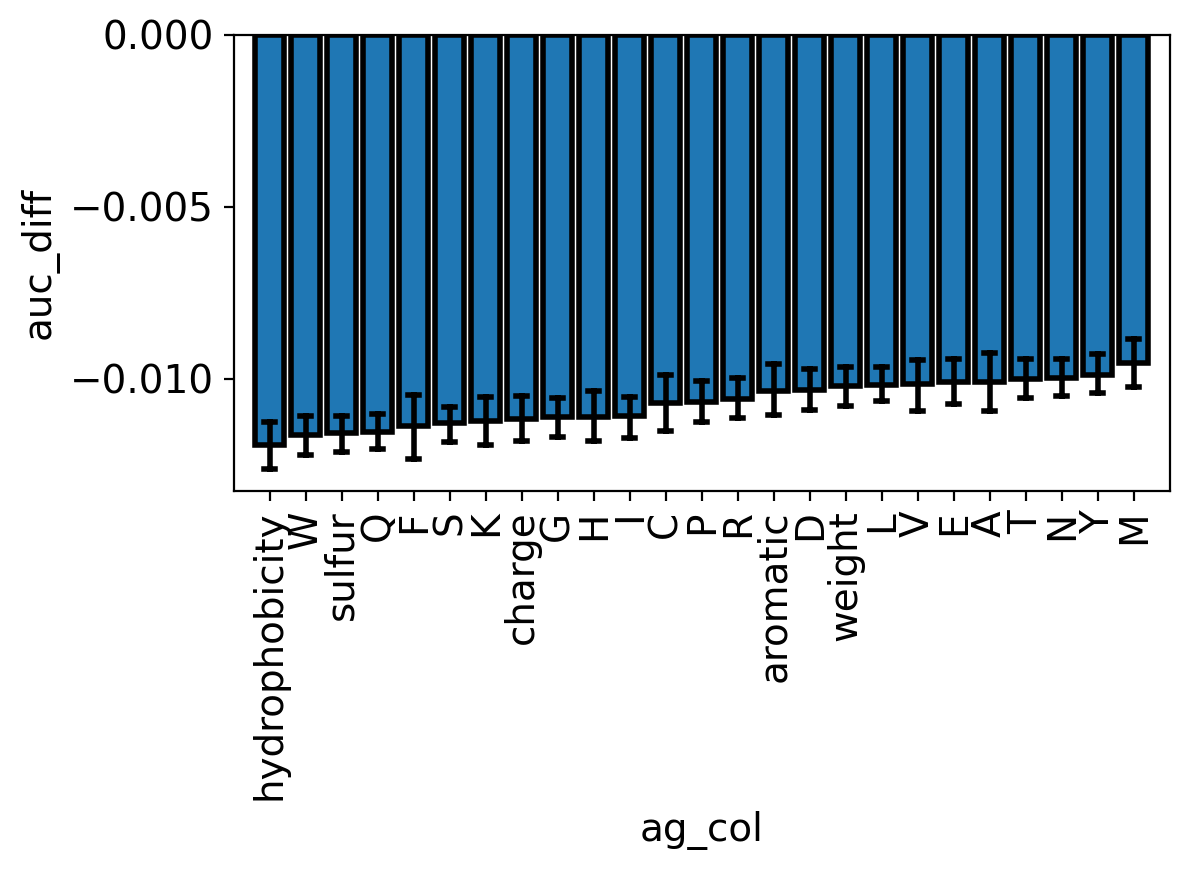

In [27]:
# get the AUC differences
df = pd.concat(els, axis=0)
df['auc_diff'] = df['auc'] - 0.8992
# now get the order
order = df.groupby('ag_col').mean(numeric_only=True)['auc_diff'].sort_values().index
# now create the bar plot
fig, ax = plt.subplots(figsize=[6, 3])
ax.grid(False)
sns.barplot(x='ag_col', y='auc_diff', data=df, order=order, ci=68, saturation=1,
            errwidth=2, capsize=0.3, linewidth=2, errcolor='k', edgecolor='k')
ax.set_xlim(-1, len(order))
ax.tick_params(axis='x', labelrotation=90)

In [28]:
# save the AG values
AG = df.groupby('ag_col').mean(numeric_only=True)['auc_diff']
print(np.mean(AG))

-0.010712474794915015


In [11]:
with open('tmp.cdr3.csv.pkl', 'rb') as f:
    els = pkl.load(f)

/tmp/ipykernel_26683/176051948.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='cdr3_col', y='auc_diff', data=df, order=order, ci=68, saturation=1,
/tmp/ipykernel_26683/176051948.py:9: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='cdr3_col', y='auc_diff', data=df, order=order, ci=68, saturation=1,
/tmp/ipykernel_26683/176051948.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(x='cdr3_col', y='auc_diff', data=df, order=order, ci=68, saturation=1,


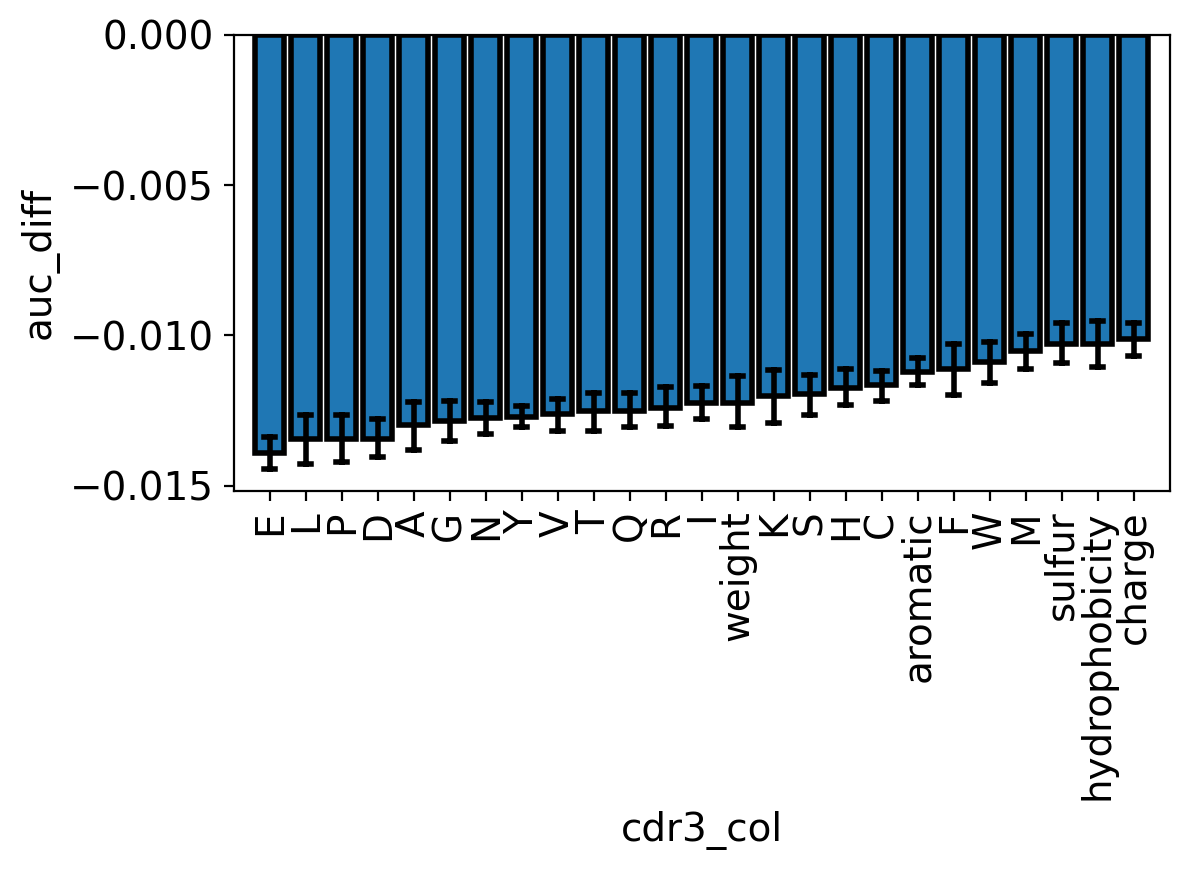

In [12]:
# get the AUC differences
df = pd.concat(els, axis=0)
df['auc_diff'] = df['auc'] - 0.8992
# now get the order
order = df.groupby('cdr3_col').mean(numeric_only=True)['auc_diff'].sort_values().index
# now create the bar plot
fig, ax = plt.subplots(figsize=[6, 3])
ax.grid(False)
sns.barplot(x='cdr3_col', y='auc_diff', data=df, order=order, ci=68, saturation=1,
            errwidth=2, capsize=0.3, linewidth=2, errcolor='k', edgecolor='k')
ax.set_xlim(-1, len(order))
ax.tick_params(axis='x', labelrotation=90)

In [14]:
# save the CDR3 values
CDR3 = df.groupby('cdr3_col').mean(numeric_only=True)['auc_diff']
print(np.mean(CDR3))

-0.012078130132130733


[Text(0.5, 0, '∆col Ag'), Text(0, 0.5, '∆col CDR3')]

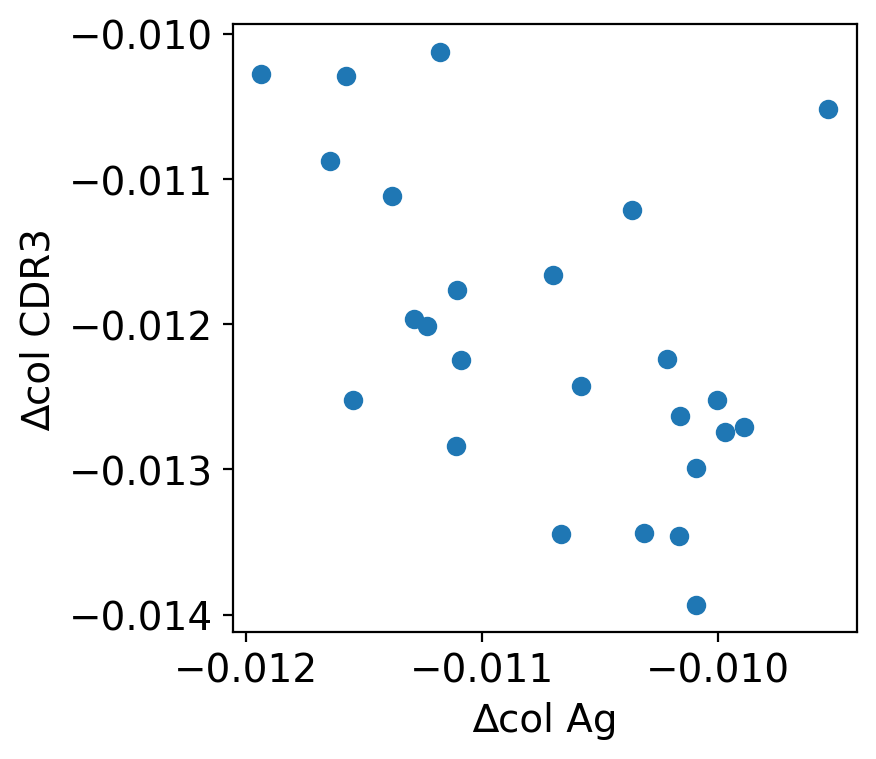

In [31]:
# now compare the two
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(AG.loc[CDR3.index], CDR3)
ss.pearsonr(AG.loc[CDR3.index], CDR3)
ax.set(xlabel='∆col Ag', ylabel='∆col CDR3')